In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pybloom import BloomFilter
import inspect
import matplotlib.font_manager
from sklearn import svm
import os
import glob
import pickle as pkl
import time
%matplotlib inline
from itertools import product
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

In [3]:
from sklearn import preprocessing
import numpy as np
import sys
from sklearn.metrics import accuracy_score
import pickle
from sklearn import mixture
import math

def ngram(X, gramsize):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    reqdim = maxlen - gramsize +1
    
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        if len(tempy) == 0:
            tempy = [paddedi]
        templeny = len(tempy)
        
        Y.append(tempy)
    return Y

def ngramEnforce(X, gramsize, reqdim):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    maxlen = reqdim + gramsize -1
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        templeny = len(tempy)
        
        Y.append(tempy)
    return np.array(Y)

def rstripfn(x):
    x = x.rstrip('\n')
    
    return x.rstrip('\n')

def getDataInString(filename):
    with open(filename) as f1:
        lst1 = map(rstripfn,f1.readlines())
    return lst1

def findngram(gramsize, lst1):
    lst1g = ngram(lst1, gramsize)

    reqdim = len(lst1g[0])
    lst1f = []
    for i in lst1g:
        lst1f.append(map(float, i))

    nplst1 = np.array(lst1f)
    return (nplst1,reqdim)

def preprocess_train(nplst1):
    lstf1 = nplst1.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    lstS1 = min_max_scaler.fit_transform(lstf1)
    return lstS1, min_max_scaler

def preprocess_test(nplst1, min_max_scaler):
    lstf1 = nplst1.astype(float)
    lstS1 = min_max_scaler.transform(lstf1)
    return lstS1

def trainfn(lstS1, n_compo, maxiter):
    clf = mixture.GaussianMixture(n_components=n_compo, covariance_type='full', max_iter=maxiter)
    clf.fit(lstS1)
    return clf

def findmeansigma(clf, lstS1):
    meanscore = np.mean(clf.score_samples(lstS1))
    meanvar = np.var(clf.score_samples(lstS1))
    sigma = math.sqrt(meanvar)
    return (meanscore, sigma)

def mypred(X, clf, mean, sigma):
    scores = clf.score_samples(X)
    print(scores)
    predictions = []
    for i in scores:
        print("diff is ",abs(i-mean))
        if(abs(i-mean)<=max(thres*sigma, 1.0/1e12)):
            predictions.append(1)
        else:
            predictions.append(-1)
    return predictions
def mypredSvm(X, clf):
    scores = clf.predict(X)
    return clf.predict(X)

def calcncompo(n):
    if(n>10000):
        return 100
    elif(n<60):
        return max(1, n/10)
    else:
        return 9

def areAllNumeric(l):
    l1 = map(isCharacterAscii, l)
    return all(l1)

def isCharacterAscii(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

def train(filename, sstableID):
    lst1 = getDataInString(filename)
    if(not areAllNumeric(lst1)):
        print("returning cause key is not numeric")
        return
    if(len(lst1) == 1):
        print('returning cause num key is 1')
        return
    nplst1, reqdim = findngram(gramsize, lst1)
    lstS1, min_max_scaler = preprocess_train(nplst1)
    n_compo = calcncompo(len(lst1))
    clf = trainfn(lstS1, n_compo, maxiter)
    mean, sigma = findmeansigma(clf, lstS1)
    models[str(sstableID)] = (clf, mean, sigma, reqdim, min_max_scaler)
    print('training done with sstableid - ', sstableID)
    return

def trainIndi(nplst1, sstableID,n_compo):
#     lst1 = getDataInString(filename)
#     if(not areAllNumeric(lst1)):
#         print("returning cause key is not numeric")
#         return
#     if(len(lst1) == 1):
#         print('returning cause num key is 1')
#         return
#     nplst1, reqdim = findngram(gramsize, lst1)
#     print("prev mean was ", np.mean(nplst1.transpose()))
#     print("prev var was ", np.var(nplst1.transpose()))
#     lstS1, min_max_scaler = preprocess_train(nplst1)
    print("passed mean was ",np.mean(nplst1.transpose()))
    print("passed sigma was ",np.var(nplst1.transpose()))
#     n_compo = calcncompo(len(lst1))
    clf = trainfn(nplst1, n_compo, maxiter)
    print("found means ")
    print(np.sort(clf.means_.transpose()[0]))
    print("cov matrix ")
    print(clf.covariances_)
    print("weights :")
    print(clf.weights_)
    mean, sigma = findmeansigma(clf, nplst1)
    print("mean is ",str(mean))
    print("sigma is ", str(sigma))
    reqdim = len(nplst1[0])
    models[str(sstableID)] = (clf, mean, sigma, reqdim)
    print('training done with sstableid - ', sstableID)
    return

def trainIndiSvm(nplst1, sstableID, nu, gamma, models):
    print("passed mean was ",np.mean(nplst1, axis=0))
    print("passed sigma was ",np.var(nplst1, axis=0))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
#     print("reqdim is ",reqdim)
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return models
def trainIndiSvmTol(nplst1, sstableID, nu, gamma, models,tol):
    print("passed mean was ",np.mean(nplst1, axis=0))
    print("passed sigma was ",np.var(nplst1, axis=0))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma, tol=tol)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
#     print("reqdim is ",reqdim)
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return models
def test(keyPredstr, sstableID):
    if(keyPredstr == ''):
        print('returning cause string is empty')
        return 0
    if(not isCharacterAscii(keyPredstr)):
        print('returning cause not numric')
        return 0
    keyPred = [str(keyPredstr)]
    if sstableID in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
        keyPredS = preprocess_test(keyPredg, min_max_scaler)
        prediction = mypred(keyPredS, clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

    
def testIndi(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred([keyPredg], clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm(keyPredg, sstableID, models):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm([keyPredg], clf)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

def testIndi2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred(keyPredg, clf, mean, sigma)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm2(keyPredg, sstableID, models):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm(keyPredg, clf)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def sizeofmodels():
    l = []
    for sstableID in models:
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
def sumsizeofmodels(models):
    agg =0
    for sstableID in models:
        clf, mean, sigma, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvm(models):
    agg =0
    for sstableID in models:
        clf, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvmReal(models):
    agg =0
    for sstableID in models:
        tempmodel, reqdim= models[str(sstableID)]
        tempsize = 8*(tempmodel.support_vectors_.shape[0]*tempmodel.support_vectors_.shape[1])+ 8*(tempmodel.dual_coef_.shape[0]*tempmodel.dual_coef_.shape[1]) + 4*(tempmodel.support_.shape[0])
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, tempsize)
    return agg
def sumsizeofbloom(bloomfilters):
    agg =0
    for f in bloomfilters.values():
        agg += f.num_bits
    agg = agg/8
    return agg

def readFileByLines(filename):
    f = open(filename, 'r')
    lst = f.readlines()
    f.close()
#     print(lst)
#     lst = map(str.rstrip, lst)
    return lst
def parseVdisk(lst):
    lst = [s.split(':') for s in lst]
#     vid = []
#     blc = [] 
    mat = []
    for ele in lst:
#         vid.append(int(ele[1]))
#         blc.append(int(ele[2], 16))
        mat.append([float(int(ele[1]))/1e0,float(int(ele[2], 16))/1e0])
#     print(vid, blc)
#     return (vid, blc)
    return mat


In [4]:
def getData():
    foldername = "/home/codebat/Documents/btp/Observations/metadata_maps/vdisk/*.db"
    files = sorted(glob.glob(foldername))
    ctr=0
    alltemptableData = []
    for fle in files:
        thisline = readFileByLines(fle)
    #     if(len(thisline)>1000):
    #         continue
        mat = parseVdisk(thisline)
        ssTableData[ctr] = np.array(mat).reshape(-1,2)
        ctr+=1
        alltemptableData+=mat
        print(ctr,len(thisline))
    # print(lines)
    alltemptableData = np.array(alltemptableData).reshape(-1,2)
    return (ssTableData, alltemptableData)
def generateGaussArrTwoDim(numcompo, gap, sigma, numelepercompo):
    mu = 0
    ans = []
    for i in range(0, numcompo):
        s = np.random.multivariate_normal([mu,0], sigma, numelepercompo)
#         print(s)
        ans.append(s)
        mu += gap
    return np.array(ans)


In [5]:
def getScalers():
    scalers = {}
    for i in range(0,len(ssTableData)):
        thistableData = ssTableData[i]
        scaler = preprocessing.StandardScaler().fit(thistableData)
        scalers[i] = scaler
    return scalers

In [6]:
# %%time
def trainFn(nu, gamma):
    # train the model on generated data
    models = {}
    for i in range(0,len(ssTableData)):
        starttime = time.time()
        thistableData = ssTableData[i]
        models = trainIndiSvm(scalers[i].transform(thistableData),i, nu, gamma, models)
        endtime = time.time()
        print(str(nu),str(gamma),"time taken ", (endtime-starttime))
    return models
def trainFnTol(nu, gamma, tol):
    # train the model on generated data
    models = {}
    for i in range(0,len(ssTableData)):
        starttime = time.time()
        thistableData = ssTableData[i]
        models = trainIndiSvmTol(scalers[i].transform(thistableData),i, nu, gamma, models, tol)
        endtime = time.time()
        print(str(nu),str(gamma),"time taken ", (endtime-starttime))
    return models

In [36]:
# pklfile = open("svmmodelstandardscaled_0.1_50", "rb")
# models = pkl.load(pklfile)
# pklfile.close()

In [7]:
# %%time
# put into bloom filter false negatives
def putIntoBloomFilters(models):
    bloomfilters = {}
    errorsTrain = {}
    for i in range(0,len(ssTableData)):
        thistableData = ssTableData[i]
        thistableDataTranspose0 = thistableData.transpose()[0]
        if removeClassifier:
            newCapacity = max(len(thistableData),1)
            print("newCapacity ",newCapacity)
            f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
            for j in range(0,len(thistableData)):
                f.add(separator.join(map(str,thistableData[j])))
            bloomfilters[i] = f
        else:
            falseNegativeAns = testIndiSvm2(scalers[i].transform(thistableData), i, models)
        #     print(falseNegativeAns)
            numFalseNeg = falseNegativeAns.tolist().count(-1)
        #     newCapacity = int(capacityBloom*1.0*numFalseNeg/len(thistableData))
            newCapacity = max(numFalseNeg,1)
            print("newCapacity ",newCapacity)
            f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
            for j in range(0,len(thistableData)):
                if(falseNegativeAns[j]==-1 or removeClassifier):
        #             print("adding ", thistableDataTranspose0[j])
                    f.add(separator.join(map(str,thistableData[j])))
            bloomfilters[i] = f
        errorsTrain[i] = newCapacity
    return (bloomfilters,errorsTrain)

In [8]:
# %%time
def performTests(models, bloomfilters):
    # create test data
    # For now test data is all data
    # calculate false positives for test data
    truePositive_c=0
    truePositive_bf=0
    truePositive=0
    falsePositive_c=0
    falsePositive_bf=0
    falsePositive=0
    trueNegative=0
    for i in range(0, len(ssTableData)):
        print("on sstable number ", i)
        thistableData = ssTableData[i]
        thistableDataTranspose0 = thistableData.transpose()[0]
        for elemind in range(0,len(thistableData),skipFactor):
            elem = thistableData[elemind]
            for j in range(0,len(ssTableData)):
                if removeClassifier:
                    cAnswer = False
                else:
                    cAnswer = (testIndiSvm(scalers[j].transform([elem])[0],j, models)==1)
    #             print(cAnswer)
                if not cAnswer:
                    bfAnswer = separator.join(map(str,elem)) in bloomfilters[j]
                    finAnswer = bfAnswer
                else:
                    bfAnswer = None
                    finAnswer = cAnswer
                if finAnswer:
                    if(i==j):
                        #True answer true positive
                        #break because you found answer
                        truePositive+=1
                        if bfAnswer is None:
                            truePositive_c+=1
                        else:
                            truePositive_bf+=1
                        break
                    else:
                        #False answer false positive
                        falsePositive+=1
                        if bfAnswer is None:
                            falsePositive_c+=1
                        else:
                            falsePositive_bf+=1
                else:
                    if(i==j):
                        raise ValueEroor("not possible")
                    else:
                        #True answer true negative
                        trueNegative+=1
    fprate = falsePositive*1.0/(falsePositive+trueNegative)
    return (fprate,
            truePositive_c,truePositive_bf,truePositive,
            falsePositive_c,falsePositive_bf,falsePositive,
            trueNegative)
                
        


In [9]:
def persistModel(models, nu, gamma):
    pickle_out = open("svmModels/svmmodelstandardscaled_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(models, pickle_out)
    pickle_out.close()

In [10]:
def loadModel(nu, gamma):
    pickle_out = open("svmModels/svmmodelstandardscaled_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    models = pkl.load(pickle_out)
    pickle_out.close()
    return models

In [11]:
def persistBloomFilters(bloomfilters, nu, gamma):
    pickle_out = open("bloomfilters/bloomfilters_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(bloomfilters, pickle_out)
    pickle_out.close()

In [12]:
def loadBloomFilters(nu, gamma):
    pickle_out = open("bloomfilters/bloomfilters_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    bloomfilters = pkl.load(pickle_out)
    pickle_out.close()
    return bloomfilters

In [13]:
def persistObservations(obs, nu, gamma):
    pickle_out = open("Observations/observations_"+namePrefix+str(nu)+"_"+str(gamma),"wb")
    pkl.dump(obs, pickle_out)
    pickle_out.close()

In [14]:
def loadObservations(nu, gamma):
    pickle_out = open("Observations/observations_"+namePrefix+str(nu)+"_"+str(gamma),"rb")
    obs = pkl.load(pickle_out)
    pickle_out.close()
    return obs

In [15]:
def persistTimes(obs):
    pickle_out = open("times/times_"+namePrefix,"wb")
    pkl.dump(obs, pickle_out)
    pickle_out.close()

In [16]:
def loadTimes():
    pickle_out = open("times/times_"+namePrefix,"rb")
    obs = pkl.load(pickle_out)
    pickle_out.close()
    return obs

In [17]:
def ensemble(nu, gamma):
    print(nu,gamma)
    starttime = time.time()
    models = trainFn(nu, gamma)
    persistModel(models, nu, gamma)
#     models = loadModel(nu, gamma)
    (bloomfilters, errorTrain) = putIntoBloomFilters(models)
    persistBloomFilters(bloomfilters, nu, gamma)
    (fprate,
    truePositive_c,truePositive_bf,truePositive,
    falsePositive_c,falsePositive_bf,falsePositive,
    trueNegative) = performTests(models, bloomfilters)
    observations = (errorTrain, fprate,
                    truePositive_c,truePositive_bf,truePositive,
                    falsePositive_c,falsePositive_bf,falsePositive,
                    trueNegative)
    persistObservations(observations, nu, gamma)
    endtime = time.time()
    return (endtime-starttime, nu, gamma)

In [53]:
numclustersPerSStable = 10
numclustersPerSStableForTrain = numclustersPerSStable
numSstable = 24
numelePerCluster = 200
gapBetweenClusters = 1.0
clusterSigma = [[0.1,0],[0,1]]
ssTableData = {}
namePrefix = "20nu20gammagaussian"
separator = ":"
skipFactor = 1
errorRate = 0.1

In [ ]:
ss

In [54]:
gramsize = -1
maxiter = 100
models = {} # storing models based on sstable ids
nu = 0.1
gamma = 10
removeClassifier = False

In [55]:
# Generate the data
alltemptableData = generateGaussArrTwoDim(
    numclustersPerSStable*numSstable, gapBetweenClusters, clusterSigma, numelePerCluster )
np.random.shuffle(alltemptableData)


In [56]:
for i in range(0,numSstable):
    thistableData = alltemptableData[i*numclustersPerSStable:(i+1)*numclustersPerSStable]
    ssTableData[i] = thistableData.reshape(-1,thistableData.shape[2])

In [ ]:
scalers = getScalers()
nus = np.logspace(-6,0,20)
gammas = np.logspace(-6,3,20)
# nus = np.logspace(-1,0,1)
# gammas = np.logspace(0,3,1)
num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(ensemble)(i,j) for i,j in tqdm(product(nus, gammas)))
print(results)
# for nu, gamma in product(nus, gammas):
#     ensemble(nu,gamma)
    



0it [00:00, ?it/s]

16it [02:29,  9.33s/it]

24it [04:54, 11.97s/it]

32it [07:24, 14.00s/it]

40it [09:49, 15.23s/it]

48it [12:21, 16.36s/it]

56it [14:50, 17.06s/it]

64it [17:11, 17.24s/it]

72it [19:40, 17.65s/it]

80it [22:05, 17.79s/it]

In [59]:
len(results)

400

In [19]:
%%time
thistableData = ssTableData[0]
trainIndiSvm(scalers[0].transform(thistableData),0, nu, gamma, models)

('passed mean was ', array([ 2.11297646e-15, -3.04201109e-17]))
('passed sigma was ', array([1., 1.]))
('training done with sstableid - ', 0)
CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 14.7 ms


In [ ]:
# gramsize = -1
# maxiter = 100
# # models = {} # storing models based on sstable ids
# # nu = 0.1
# # gamma = 1
# removeClassifier = False

In [ ]:
# # thres = -0.1
# # bloomfilters = {}
# capacityBloom = 30000
# errorRate = 0.1
# skipFactor = 50

In [ ]:
# ssTableData = {}
# separator = ":"
# namePrefix = "20nu20gammagaussian"

In [ ]:
(ssTableData, alltemptableData) = getData()
scalers = getScalers()
# nus = np.logspace(-6,0,20)
# gammas = np.logspace(-6,3,20)
# # nus = np.logspace(-1,0,1)
# # gammas = np.logspace(0,3,1)
# num_cores = multiprocessing.cpu_count()

# results = Parallel(n_jobs=num_cores)(delayed(ensemble)(i,j) for i,j in tqdm(product(nus, gammas)))
# print(results)
# # for nu, gamma in product(nus, gammas):
# #     ensemble(nu,gamma)
    
# # models = trainFn(0.1,1)

In [60]:
mshape = (20,20)

In [ ]:
nus = np.logspace(-6,0,mshape[0])
gammas = np.logspace(-6,3,mshape[1])

In [ ]:
results = loadTimes()

In [62]:
namePrefix

'20nu20gammagaussian'

In [61]:
results

[(148.73121094703674, 1e-06, 1e-06),
 (149.44982194900513, 1e-06, 2.976351441631319e-06),
 (150.07415318489075, 1e-06, 8.858667904100832e-06),
 (147.92520308494568, 1e-06, 2.6366508987303556e-05),
 (148.03800916671753, 1e-06, 7.847599703514606e-05),
 (147.5263888835907, 1e-06, 0.00023357214690901214),
 (148.66361689567566, 1e-06, 0.0006951927961775605),
 (152.91288590431213, 1e-06, 0.002069138081114788),
 (151.23100090026855, 1e-06, 0.00615848211066026),
 (147.39360308647156, 1e-06, 0.01832980710832434),
 (144.00900888442993, 1e-06, 0.05455594781168514),
 (149.03634309768677, 1e-06, 0.1623776739188721),
 (149.34025692939758, 1e-06, 0.4832930238571752),
 (150.40545296669006, 1e-06, 1.438449888287663),
 (148.69435811042786, 1e-06, 4.281332398719387),
 (150.528822183609, 1e-06, 12.742749857031322),
 (149.9725980758667, 1e-06, 37.92690190732246),
 (149.61366319656372, 1e-06, 112.88378916846884),
 (149.21890211105347, 1e-06, 335.9818286283774),
 (149.67032599449158, 1e-06, 1000.0),
 (149.74

In [63]:
nus

array([1.00000000e-06, 2.06913808e-06, 4.28133240e-06, 8.85866790e-06,
       1.83298071e-05, 3.79269019e-05, 7.84759970e-05, 1.62377674e-04,
       3.35981829e-04, 6.95192796e-04, 1.43844989e-03, 2.97635144e-03,
       6.15848211e-03, 1.27427499e-02, 2.63665090e-02, 5.45559478e-02,
       1.12883789e-01, 2.33572147e-01, 4.83293024e-01, 1.00000000e+00])

In [64]:
gammas

array([1.00000000e-06, 2.97635144e-06, 8.85866790e-06, 2.63665090e-05,
       7.84759970e-05, 2.33572147e-04, 6.95192796e-04, 2.06913808e-03,
       6.15848211e-03, 1.83298071e-02, 5.45559478e-02, 1.62377674e-01,
       4.83293024e-01, 1.43844989e+00, 4.28133240e+00, 1.27427499e+01,
       3.79269019e+01, 1.12883789e+02, 3.35981829e+02, 1.00000000e+03])

In [65]:
obsdic = {}
fprates = np.zeros(mshape)
fprateslist = []
bfsizelist = []
modelSizeList = []
fpdic = {}
for i,j in product(nus,gammas):
    print(i,j)
    try:
        obs = loadObservations(i,j)
        fprateslist.append(obs[1])
        fpdic[(i,j)] = obs[1]
        print(obs[1])
    except IOError:
        obs = None
        fprateslist.append(1)
        fpdic[(i,j)] = None
        print(obs)
    try:
        bloomfilters = loadBloomFilters(i,j)
        tempsize = sumsizeofbloom(bloomfilters)
        bfsizelist.append(tempsize)
        print(tempsize)
    except IOError:
        tempsize = None
        bfsizelist.append(1e6)
        print(tempsize)
    try:
        models = loadModel(i,j)
        tempsize = sumsizeofmodelssvmReal(models)
        modelSizeList.append(tempsize)
        print(tempsize)
    except IOError:
        tempsize = None
        modelSizeList.append(1e10)
        print(tempsize)
    
#     fprateslist.append(obs[1])
#     fpdic[(i,j)] = obs[1]
    obsdic[(i,j)] = obs
fprateslist = np.array(fprateslist).reshape(mshape)
bfsizelist = np.array(bfsizelist).reshape(mshape)
modelSizeList = np.array(modelSizeList).reshape(mshape)
totalSizeList = bfsizelist + modelSizeList

(1e-06, 1e-06)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(1e-06, 2.976351441631319e-06)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(1e-06, 8.858667904100832e-06)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(1e-06, 2.6366508987303556e-05)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 

('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(4.281332398719396e-06, 2.6366508987303556e-05)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(4.281332398719396e-06, 7.847599703514606e-05)
0.0136503623188
57516
('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(4.281332398719396e-06, 0.00023357214690901214)
0.0136503623188
57516
('20', 28)
('21',

('20', 28)
('21', 28)
('22', 28)
('23', 28)
('1', 28)
('0', 28)
('3', 28)
('2', 28)
('5', 28)
('4', 28)
('7', 28)
('6', 28)
('9', 28)
('8', 28)
('11', 28)
('10', 28)
('13', 28)
('12', 28)
('15', 28)
('14', 28)
('17', 28)
('16', 28)
('19', 28)
('18', 28)
672
(1.8329807108324375e-05, 0.002069138081114788)
0.971425724638
2117
('20', 56)
('21', 56)
('22', 56)
('23', 56)
('1', 56)
('0', 56)
('3', 56)
('2', 56)
('5', 56)
('4', 56)
('7', 56)
('6', 56)
('9', 56)
('8', 56)
('11', 56)
('10', 56)
('13', 56)
('12', 56)
('15', 56)
('14', 56)
('17', 56)
('16', 56)
('19', 56)
('18', 56)
1344
(1.8329807108324375e-05, 0.00615848211066026)
0.991114130435
144
('20', 56)
('21', 56)
('22', 56)
('23', 56)
('1', 56)
('0', 56)
('3', 84)
('2', 56)
('5', 56)
('4', 56)
('7', 56)
('6', 56)
('9', 56)
('8', 56)
('11', 84)
('10', 56)
('13', 56)
('12', 56)
('15', 56)
('14', 56)
('17', 56)
('16', 56)
('19', 56)
('18', 56)
1400
(1.8329807108324375e-05, 0.01832980710832434)
0.991487318841
121
('20', 84)
('21', 56)
('22'

0.913608695652
507
('20', 168)
('21', 140)
('22', 112)
('23', 112)
('1', 112)
('0', 140)
('3', 112)
('2', 112)
('5', 168)
('4', 112)
('7', 196)
('6', 140)
('9', 112)
('8', 168)
('11', 112)
('10', 168)
('13', 168)
('12', 112)
('15', 140)
('14', 140)
('17', 112)
('16', 140)
('19', 112)
('18', 112)
3220
(7.847599703514606e-05, 0.1623776739188721)
0.831744565217
2947
('20', 308)
('21', 336)
('22', 252)
('23', 308)
('1', 252)
('0', 336)
('3', 224)
('2', 336)
('5', 280)
('4', 392)
('7', 392)
('6', 252)
('9', 252)
('8', 364)
('11', 224)
('10', 280)
('13', 392)
('12', 252)
('15', 392)
('14', 224)
('17', 336)
('16', 252)
('19', 280)
('18', 280)
7196
(7.847599703514606e-05, 0.4832930238571752)
0.585601449275
11962
('20', 644)
('21', 616)
('22', 532)
('23', 812)
('1', 644)
('0', 644)
('3', 784)
('2', 560)
('5', 700)
('4', 588)
('7', 560)
('6', 672)
('9', 784)
('8', 644)
('11', 588)
('10', 672)
('13', 616)
('12', 812)
('15', 672)
('14', 784)
('17', 672)
('16', 560)
('19', 616)
('18', 840)
16016
(7

('20', 392)
('21', 308)
('22', 308)
('23', 308)
('1', 308)
('0', 280)
('3', 308)
('2', 336)
('5', 392)
('4', 308)
('7', 420)
('6', 252)
('9', 308)
('8', 336)
('11', 224)
('10', 308)
('13', 392)
('12', 308)
('15', 336)
('14', 252)
('17', 252)
('16', 252)
('19', 336)
('18', 336)
7560
(0.0003359818286283781, 0.4832930238571752)
0.627641304348
5237
('20', 896)
('21', 896)
('22', 896)
('23', 980)
('1', 840)
('0', 784)
('3', 980)
('2', 840)
('5', 1008)
('4', 896)
('7', 896)
('6', 868)
('9', 924)
('8', 1036)
('11', 700)
('10', 812)
('13', 952)
('12', 1064)
('15', 896)
('14', 924)
('17', 1008)
('16', 1176)
('19', 840)
('18', 1092)
22204
(0.0003359818286283781, 1.438449888287663)
0.504536231884
10213
('20', 1876)
('21', 1484)
('22', 2072)
('23', 2128)
('1', 1792)
('0', 1792)
('3', 2296)
('2', 1512)
('5', 1932)
('4', 1568)
('7', 1848)
('6', 1876)
('9', 1960)
('8', 1960)
('11', 1680)
('10', 1764)
('13', 1904)
('12', 1624)
('15', 1792)
('14', 1512)
('17', 1624)
('16', 1680)
('19', 1820)
('18', 226

('20', 392)
('21', 336)
('22', 280)
('23', 280)
('1', 280)
('0', 308)
('3', 252)
('2', 252)
('5', 364)
('4', 224)
('7', 252)
('6', 224)
('9', 224)
('8', 308)
('11', 196)
('10', 336)
('13', 336)
('12', 252)
('15', 308)
('14', 224)
('17', 196)
('16', 280)
('19', 224)
('18', 252)
6580
(0.0014384498882876629, 0.4832930238571752)
0.619856884058
1643
('20', 1204)
('21', 980)
('22', 952)
('23', 980)
('1', 840)
('0', 616)
('3', 868)
('2', 840)
('5', 1092)
('4', 1064)
('7', 1064)
('6', 1008)
('9', 1120)
('8', 1148)
('11', 784)
('10', 924)
('13', 952)
('12', 840)
('15', 812)
('14', 924)
('17', 840)
('16', 1064)
('19', 840)
('18', 924)
22680
(0.0014384498882876629, 1.438449888287663)
0.509570652174
5863
('20', 2464)
('21', 1904)
('22', 2520)
('23', 3780)
('1', 2184)
('0', 2212)
('3', 3500)
('2', 1764)
('5', 2912)
('4', 1652)
('7', 2604)
('6', 2492)
('9', 2520)
('8', 2380)
('11', 1736)
('10', 2072)
('13', 2632)
('12', 1792)
('15', 2464)
('14', 1820)
('17', 1512)
('16', 2100)
('19', 2044)
('18', 34

('20', 392)
('21', 392)
('22', 392)
('23', 420)
('1', 392)
('0', 392)
('3', 420)
('2', 392)
('5', 364)
('4', 392)
('7', 392)
('6', 392)
('9', 420)
('8', 392)
('11', 392)
('10', 392)
('13', 392)
('12', 364)
('15', 392)
('14', 420)
('17', 392)
('16', 392)
('19', 420)
('18', 364)
9464
(0.00615848211066026, 0.05455594781168514)
0.921422101449
359
('20', 392)
('21', 392)
('22', 392)
('23', 392)
('1', 420)
('0', 392)
('3', 392)
('2', 392)
('5', 420)
('4', 420)
('7', 420)
('6', 392)
('9', 392)
('8', 392)
('11', 392)
('10', 420)
('13', 420)
('12', 448)
('15', 392)
('14', 392)
('17', 420)
('16', 420)
('19', 392)
('18', 392)
9688
(0.00615848211066026, 0.1623776739188721)
0.826157608696
385
('20', 504)
('21', 448)
('22', 448)
('23', 504)
('1', 504)
('0', 476)
('3', 476)
('2', 476)
('5', 476)
('4', 504)
('7', 476)
('6', 448)
('9', 504)
('8', 476)
('11', 532)
('10', 504)
('13', 476)
('12', 476)
('15', 476)
('14', 476)
('17', 532)
('16', 476)
('19', 504)
('18', 504)
11676
(0.00615848211066026, 0.483

0.947009057971
1520
('20', 1512)
('21', 1484)
('22', 1512)
('23', 1512)
('1', 1540)
('0', 1540)
('3', 1512)
('2', 1512)
('5', 1484)
('4', 1512)
('7', 1540)
('6', 1512)
('9', 1540)
('8', 1540)
('11', 1540)
('10', 1484)
('13', 1512)
('12', 1512)
('15', 1512)
('14', 1484)
('17', 1512)
('16', 1512)
('19', 1512)
('18', 1512)
36344
(0.026366508987303555, 0.00615848211066026)
0.944382246377
1525
('20', 1512)
('21', 1484)
('22', 1512)
('23', 1512)
('1', 1540)
('0', 1540)
('3', 1512)
('2', 1512)
('5', 1484)
('4', 1512)
('7', 1512)
('6', 1512)
('9', 1512)
('8', 1484)
('11', 1512)
('10', 1484)
('13', 1512)
('12', 1484)
('15', 1512)
('14', 1512)
('17', 1512)
('16', 1540)
('19', 1512)
('18', 1512)
36232
(0.026366508987303555, 0.01832980710832434)
0.93594384058
1530
('20', 1540)
('21', 1512)
('22', 1540)
('23', 1484)
('1', 1512)
('0', 1540)
('3', 1512)
('2', 1512)
('5', 1512)
('4', 1512)
('7', 1512)
('6', 1540)
('9', 1512)
('8', 1540)
('11', 1512)
('10', 1484)
('13', 1512)
('12', 1512)
('15', 1540)


0.823425724638
6522
('20', 6328)
('21', 6328)
('22', 6328)
('23', 6328)
('1', 6328)
('0', 6328)
('3', 6328)
('2', 6328)
('5', 6328)
('4', 6328)
('7', 6328)
('6', 6328)
('9', 6328)
('8', 6328)
('11', 6328)
('10', 6328)
('13', 6328)
('12', 6328)
('15', 6328)
('14', 6328)
('17', 6328)
('16', 6328)
('19', 6328)
('18', 6328)
151872
(0.11288378916846883, 2.6366508987303556e-05)
0.823179347826
6494
('20', 6328)
('21', 6328)
('22', 6328)
('23', 6328)
('1', 6328)
('0', 6328)
('3', 6328)
('2', 6328)
('5', 6328)
('4', 6328)
('7', 6328)
('6', 6328)
('9', 6328)
('8', 6328)
('11', 6328)
('10', 6328)
('13', 6328)
('12', 6328)
('15', 6328)
('14', 6328)
('17', 6328)
('16', 6328)
('19', 6328)
('18', 6328)
151872
(0.11288378916846883, 7.847599703514606e-05)
0.823048913043
6499
('20', 6328)
('21', 6328)
('22', 6356)
('23', 6356)
('1', 6356)
('0', 6328)
('3', 6328)
('2', 6328)
('5', 6328)
('4', 6328)
('7', 6328)
('6', 6328)
('9', 6328)
('8', 6328)
('11', 6328)
('10', 6328)
('13', 6328)
('12', 6328)
('15', 

0.330028985507
13523
('20', 14084)
('21', 14084)
('22', 14448)
('23', 14896)
('1', 14252)
('0', 13944)
('3', 14336)
('2', 14616)
('5', 14420)
('4', 13832)
('7', 14392)
('6', 14392)
('9', 14056)
('8', 14168)
('11', 13832)
('10', 14056)
('13', 14420)
('12', 14280)
('15', 13972)
('14', 13860)
('17', 13804)
('16', 14112)
('19', 14000)
('18', 14448)
340704
(0.23357214690901212, 12.742749857031322)
0.206096014493
13647
('20', 15204)
('21', 14756)
('22', 17248)
('23', 16296)
('1', 16016)
('0', 14700)
('3', 15652)
('2', 14924)
('5', 16072)
('4', 14896)
('7', 15568)
('6', 15820)
('9', 15316)
('8', 16212)
('11', 14644)
('10', 15372)
('13', 16212)
('12', 15092)
('15', 15400)
('14', 15624)
('17', 14980)
('16', 15120)
('19', 15036)
('18', 15652)
371812
(0.23357214690901212, 37.92690190732246)
0.109101449275
13866
('20', 17696)
('21', 16744)
('22', 18844)
('23', 18060)
('1', 18060)
('0', 18704)
('3', 17696)
('2', 16744)
('5', 18508)
('4', 17696)
('7', 18620)
('6', 18004)
('9', 17640)
('8', 17948)
('

('20', 35028)
('21', 34020)
('22', 35644)
('23', 35672)
('1', 35924)
('0', 34412)
('3', 34972)
('2', 34888)
('5', 37016)
('4', 36120)
('7', 36344)
('6', 35420)
('9', 35672)
('8', 35252)
('11', 34636)
('10', 35308)
('13', 35756)
('12', 35868)
('15', 35560)
('14', 33936)
('17', 34720)
('16', 36232)
('19', 34888)
('18', 34636)
847924
(0.4832930238571752, 1000.0)
0.0173242753623
26095
('20', 40292)
('21', 37548)
('22', 39424)
('23', 39480)
('1', 41076)
('0', 38696)
('3', 38416)
('2', 38584)
('5', 41636)
('4', 40572)
('7', 40936)
('6', 39228)
('9', 39312)
('8', 39144)
('11', 39116)
('10', 38472)
('13', 40376)
('12', 39648)
('15', 40460)
('14', 37800)
('17', 38892)
('16', 41048)
('19', 37884)
('18', 38164)
946204
(1.0, 1e-06)
0.0136503623188
57516
('20', 56000)
('21', 56000)
('22', 56000)
('23', 56000)
('1', 56000)
('0', 56000)
('3', 56000)
('2', 56000)
('5', 56000)
('4', 56000)
('7', 56000)
('6', 56000)
('9', 56000)
('8', 56000)
('11', 56000)
('10', 56000)
('13', 56000)
('12', 56000)
('15',

In [ ]:
obsdic

In [66]:
minval = 1.0
for i in obsdic:
    print(i, obsdic[i][1])
    if obsdic[i][1] < minval:
        minval = obsdic[i][1]
        minpair =i

((1.8329807108324375e-05, 1000.0), 0.013905797101449275)
((0.05455594781168514, 8.858667904100832e-06), 0.9045597826086956)
((0.0006951927961775605, 2.976351441631319e-06), 0.1671358695652174)
((0.0014384498882876629, 0.01832980710832434), 0.9926376811594203)
((0.0014384498882876629, 0.0006951927961775605), 0.9964891304347826)
((8.858667904100832e-06, 2.976351441631319e-06), 0.01365036231884058)
((1.0, 112.88378916846884), 0.01365036231884058)
((1e-06, 0.002069138081114788), 0.01365036231884058)
((0.23357214690901212, 0.002069138081114788), 0.701572463768116)
((1.8329807108324375e-05, 2.976351441631319e-06), 0.01365036231884058)
((0.0006951927961775605, 0.00023357214690901214), 0.9956231884057971)
((7.847599703514606e-05, 1.438449888287663), 0.44183152173913043)
((4.281332398719396e-06, 37.92690190732246), 0.013639492753623188)
((0.0003359818286283781, 0.4832930238571752), 0.6276413043478261)
((1.0, 0.00615848211066026), 0.01365036231884058)
((3.792690190732254e-05, 335.9818286283774),

In [67]:
minval

0.013427536231884057

In [68]:
minpair

(3.792690190732254e-05, 335.9818286283774)

In [69]:
modelSizeList

array([[    672,     672,     672,     672,     672,     672,     672,
            672,     672,     700,    1344,    1344,    1344,    1344,
           1344,    1344,    1344,    1344,    1344,    1344],
       [    672,     672,     672,     672,     672,     672,     672,
            672,     672,    1260,    1960,    2828,    3136,    5292,
           5376,    5376,    5376,    5376,    5376,    5376],
       [    672,     672,     672,     672,     672,     672,     672,
            672,    1036,    1456,    2716,    4144,    5432,    6580,
          10752,   10752,   10752,   10752,   10752,   10752],
       [    672,     672,     672,     672,     672,     672,     672,
            812,    1344,    1736,    3052,    5012,    7420,   11032,
          15680,   21504,   21504,   21504,   21504,   21504],
       [    672,     672,     672,     672,     672,     672,     672,
           1344,    1400,    2100,    3164,    5852,    9996,   15792,
          22708,   36232,   43008,   4

<IPython.core.display.Javascript object>


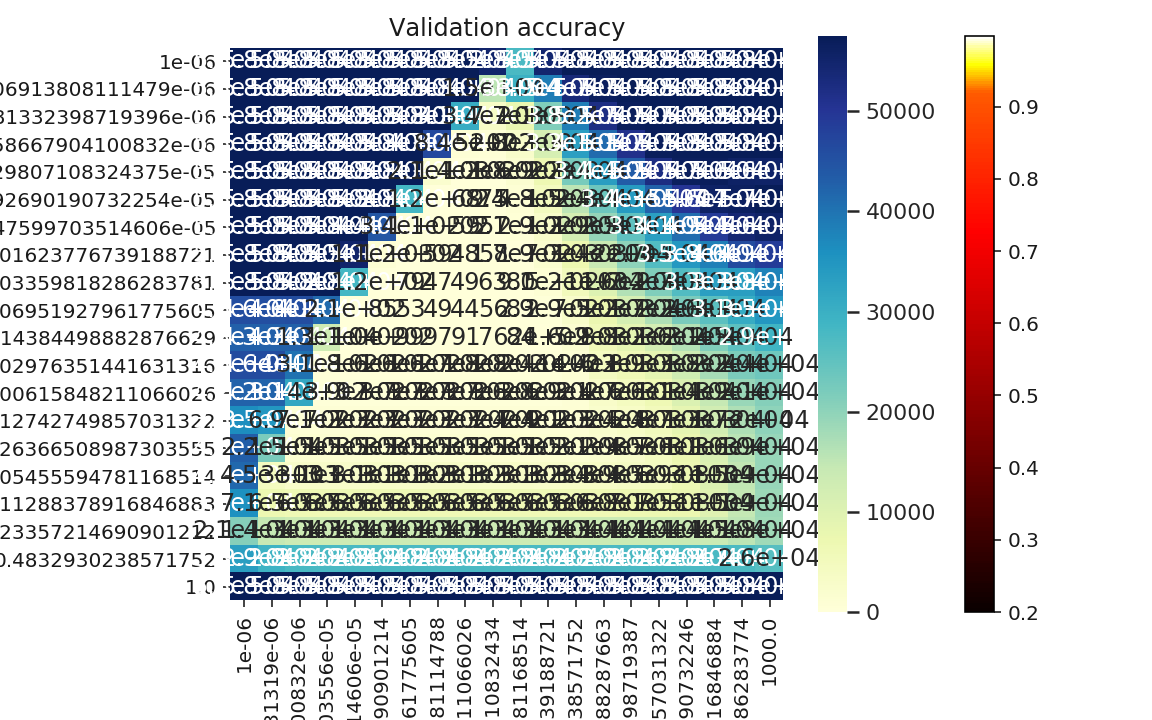

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
plt.figure(figsize=(8,5))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(fprateslist, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.yticks(np.arange(len(nus)), nus, rotation=45)
plt.xticks(np.arange(len(gammas)), gammas)
plt.title('Validation accuracy')
plt.show()

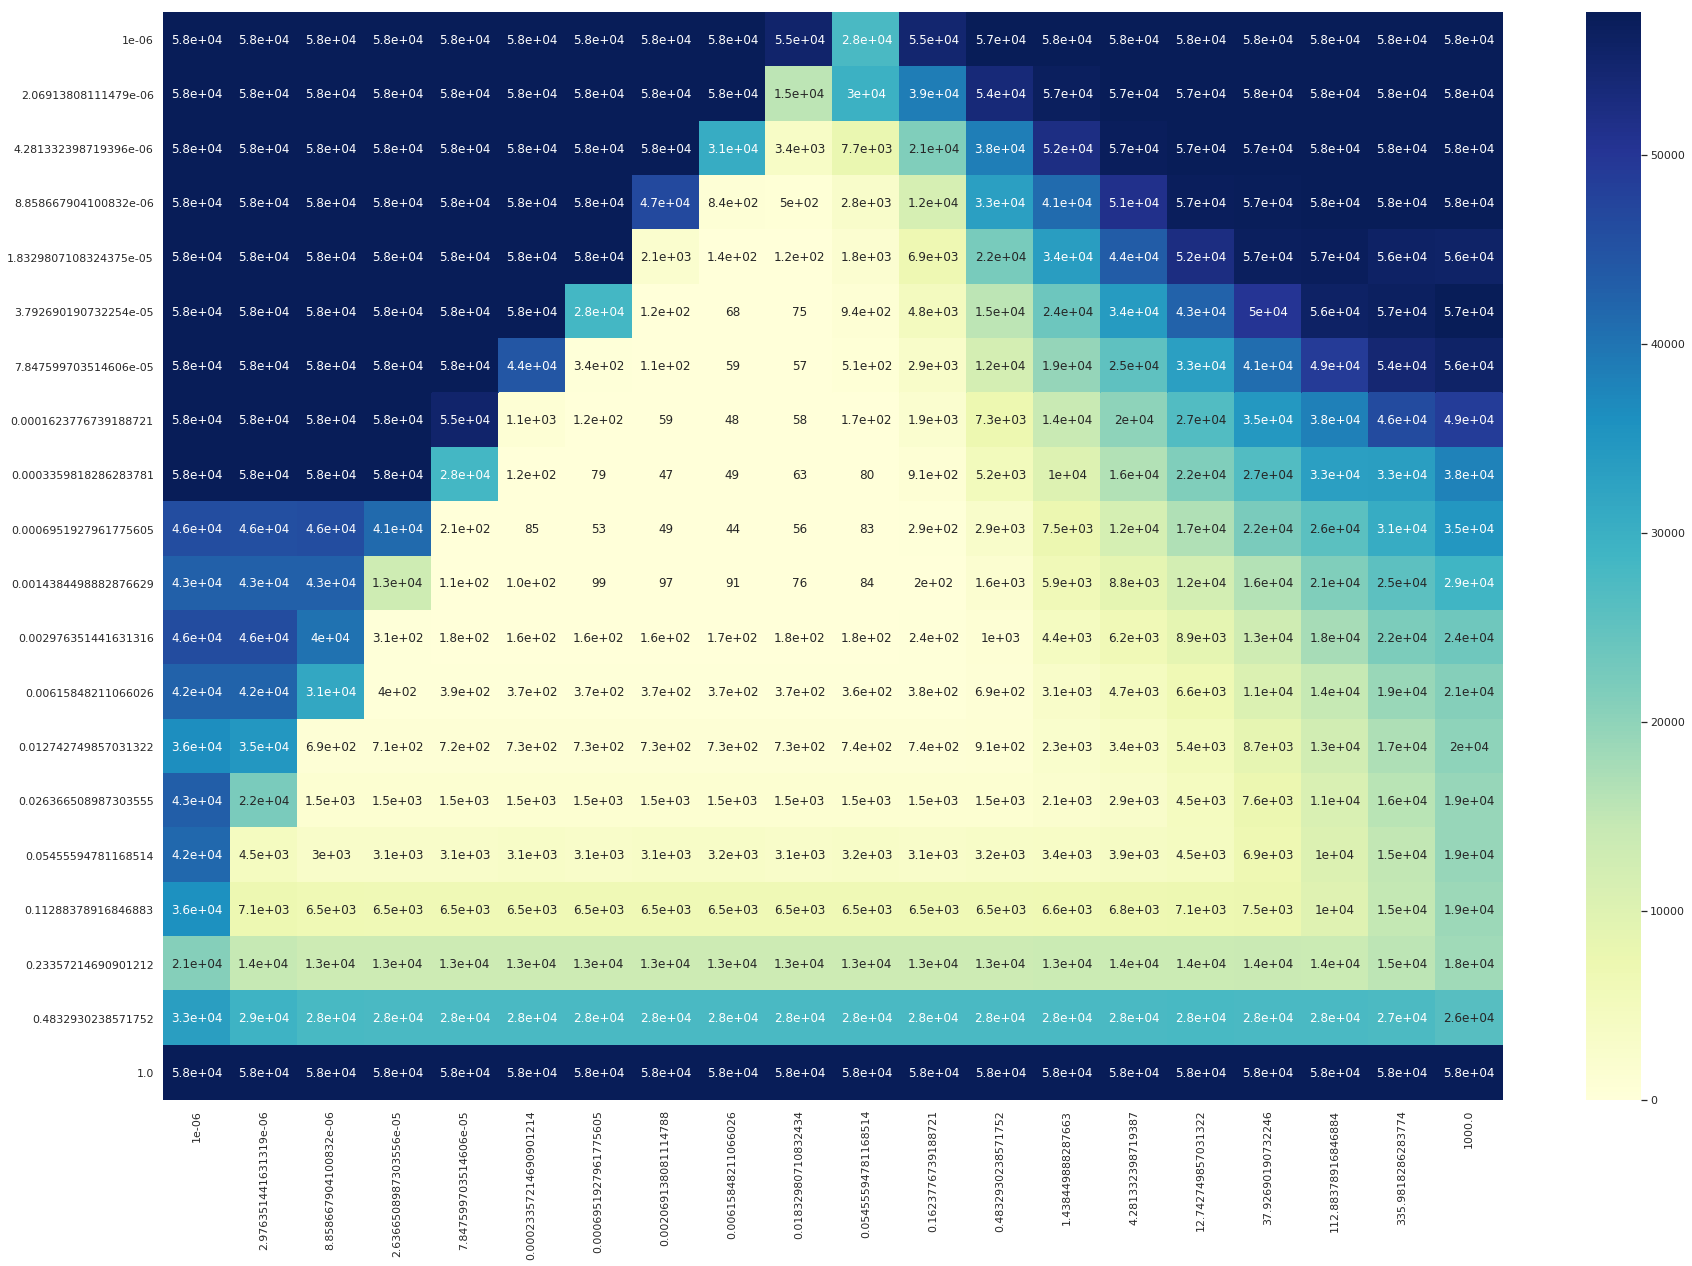

In [74]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(bfsizelist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

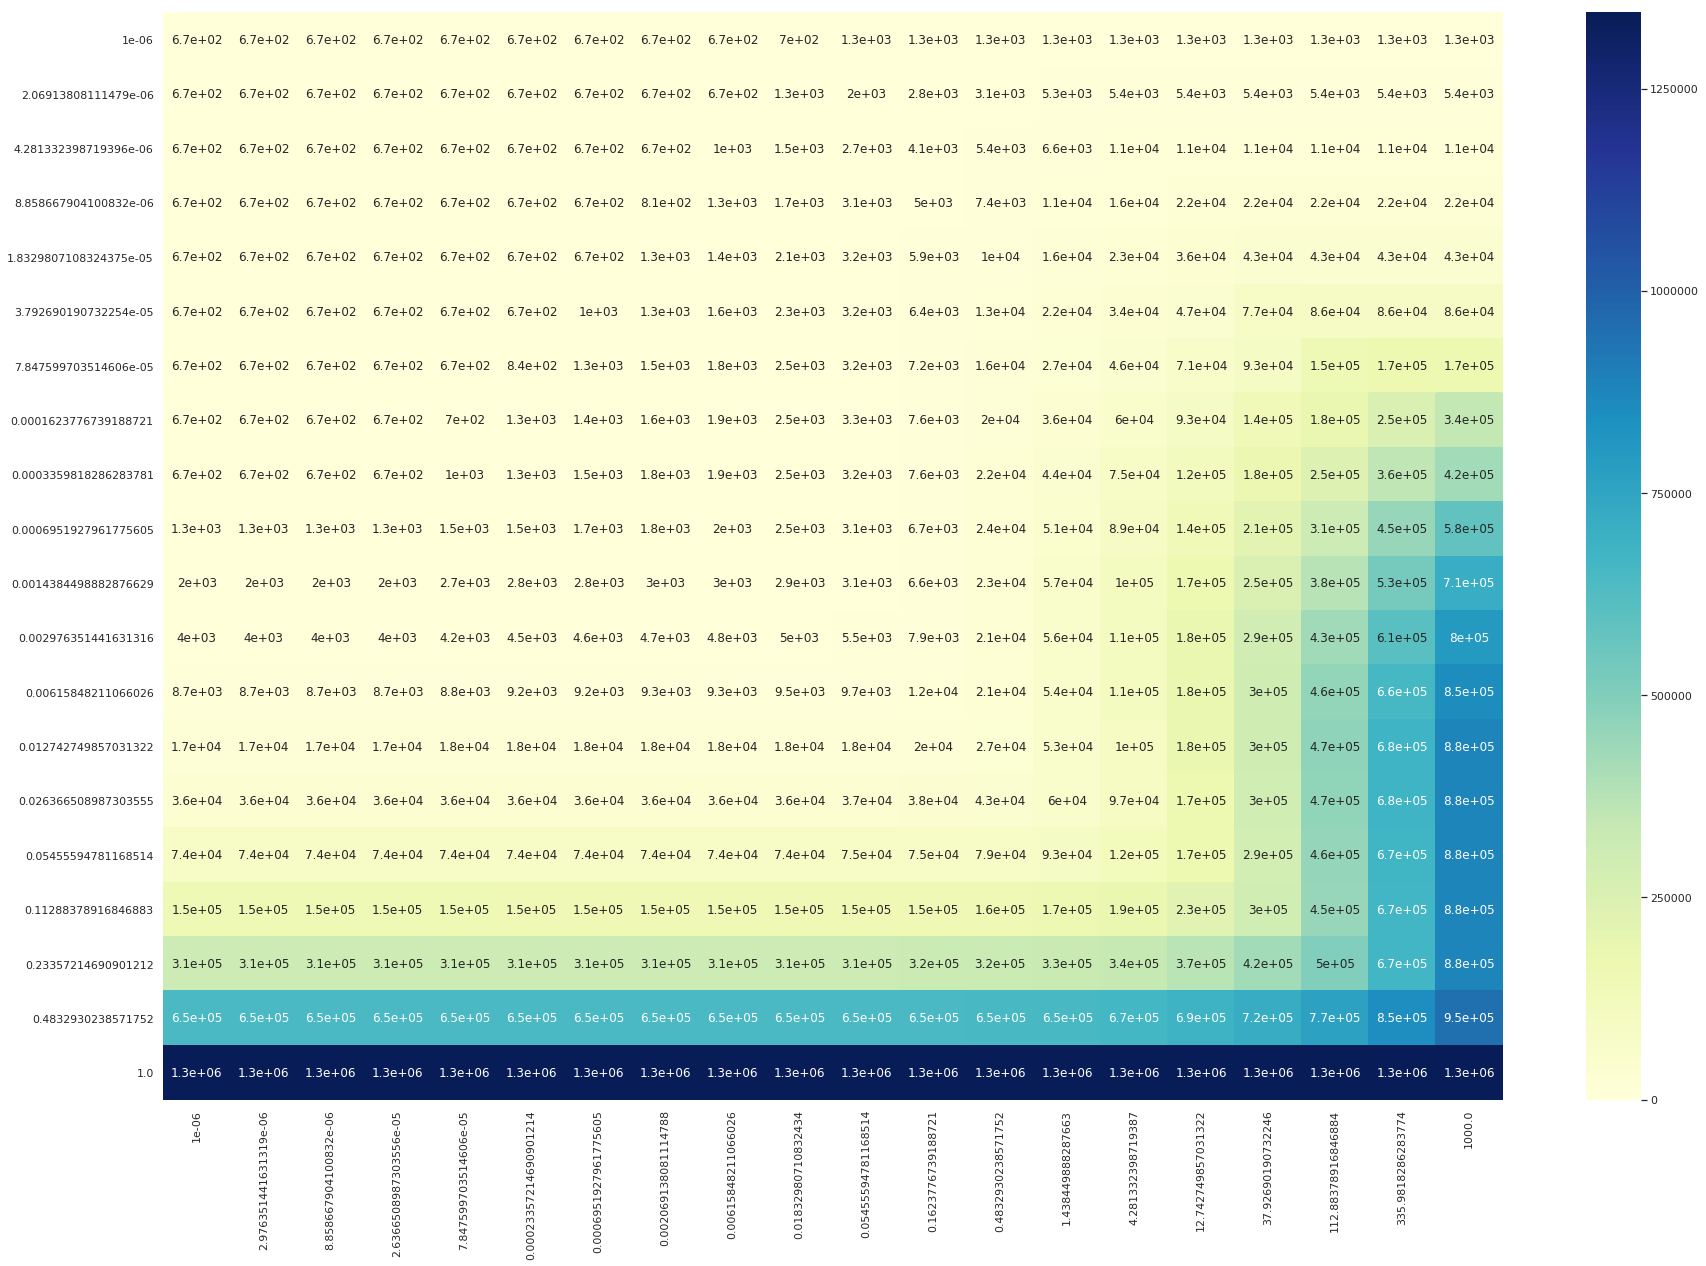

In [75]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

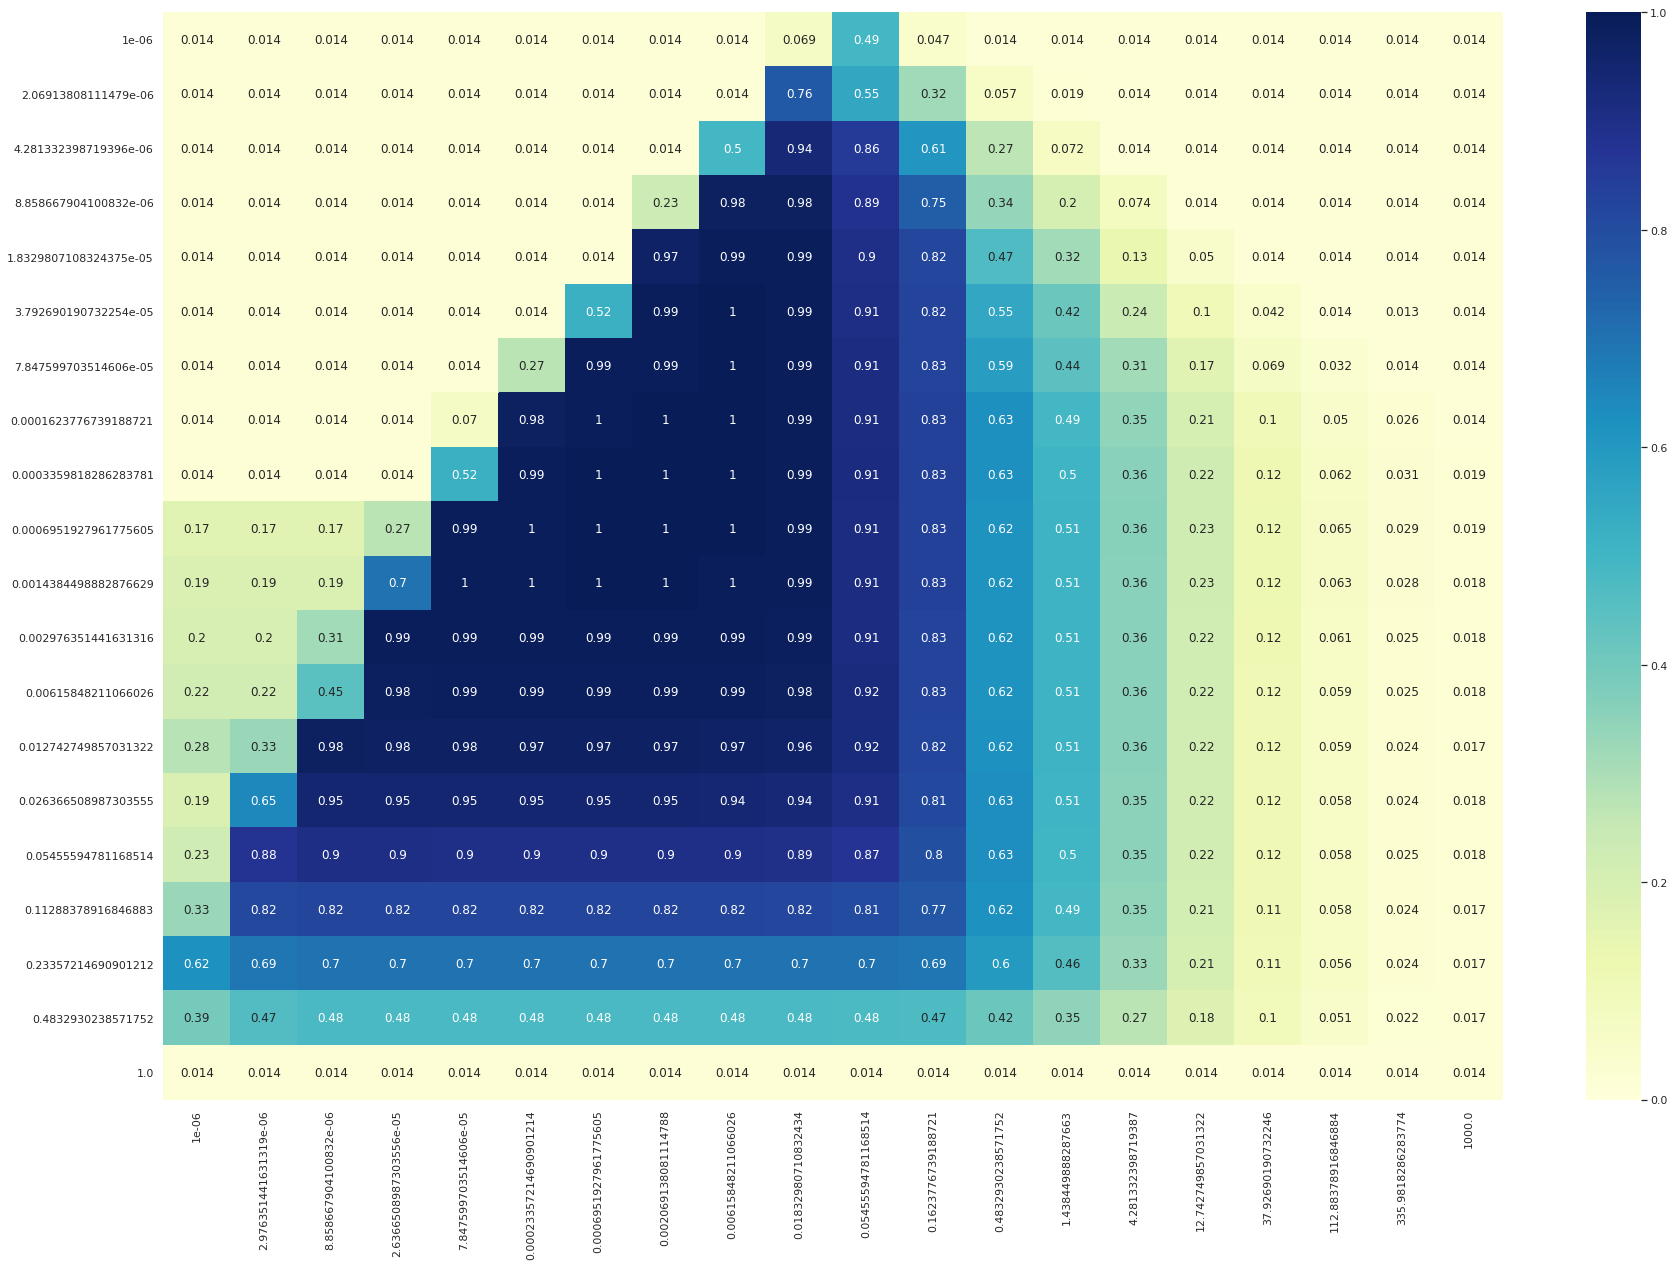

In [76]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(fprateslist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0,vmax=1, annot=True)

In [1]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(totalSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

NameError: name 'totalSizeList' is not defined

In [78]:
(fprateslist * bfsizelist).shape

(20, 20)

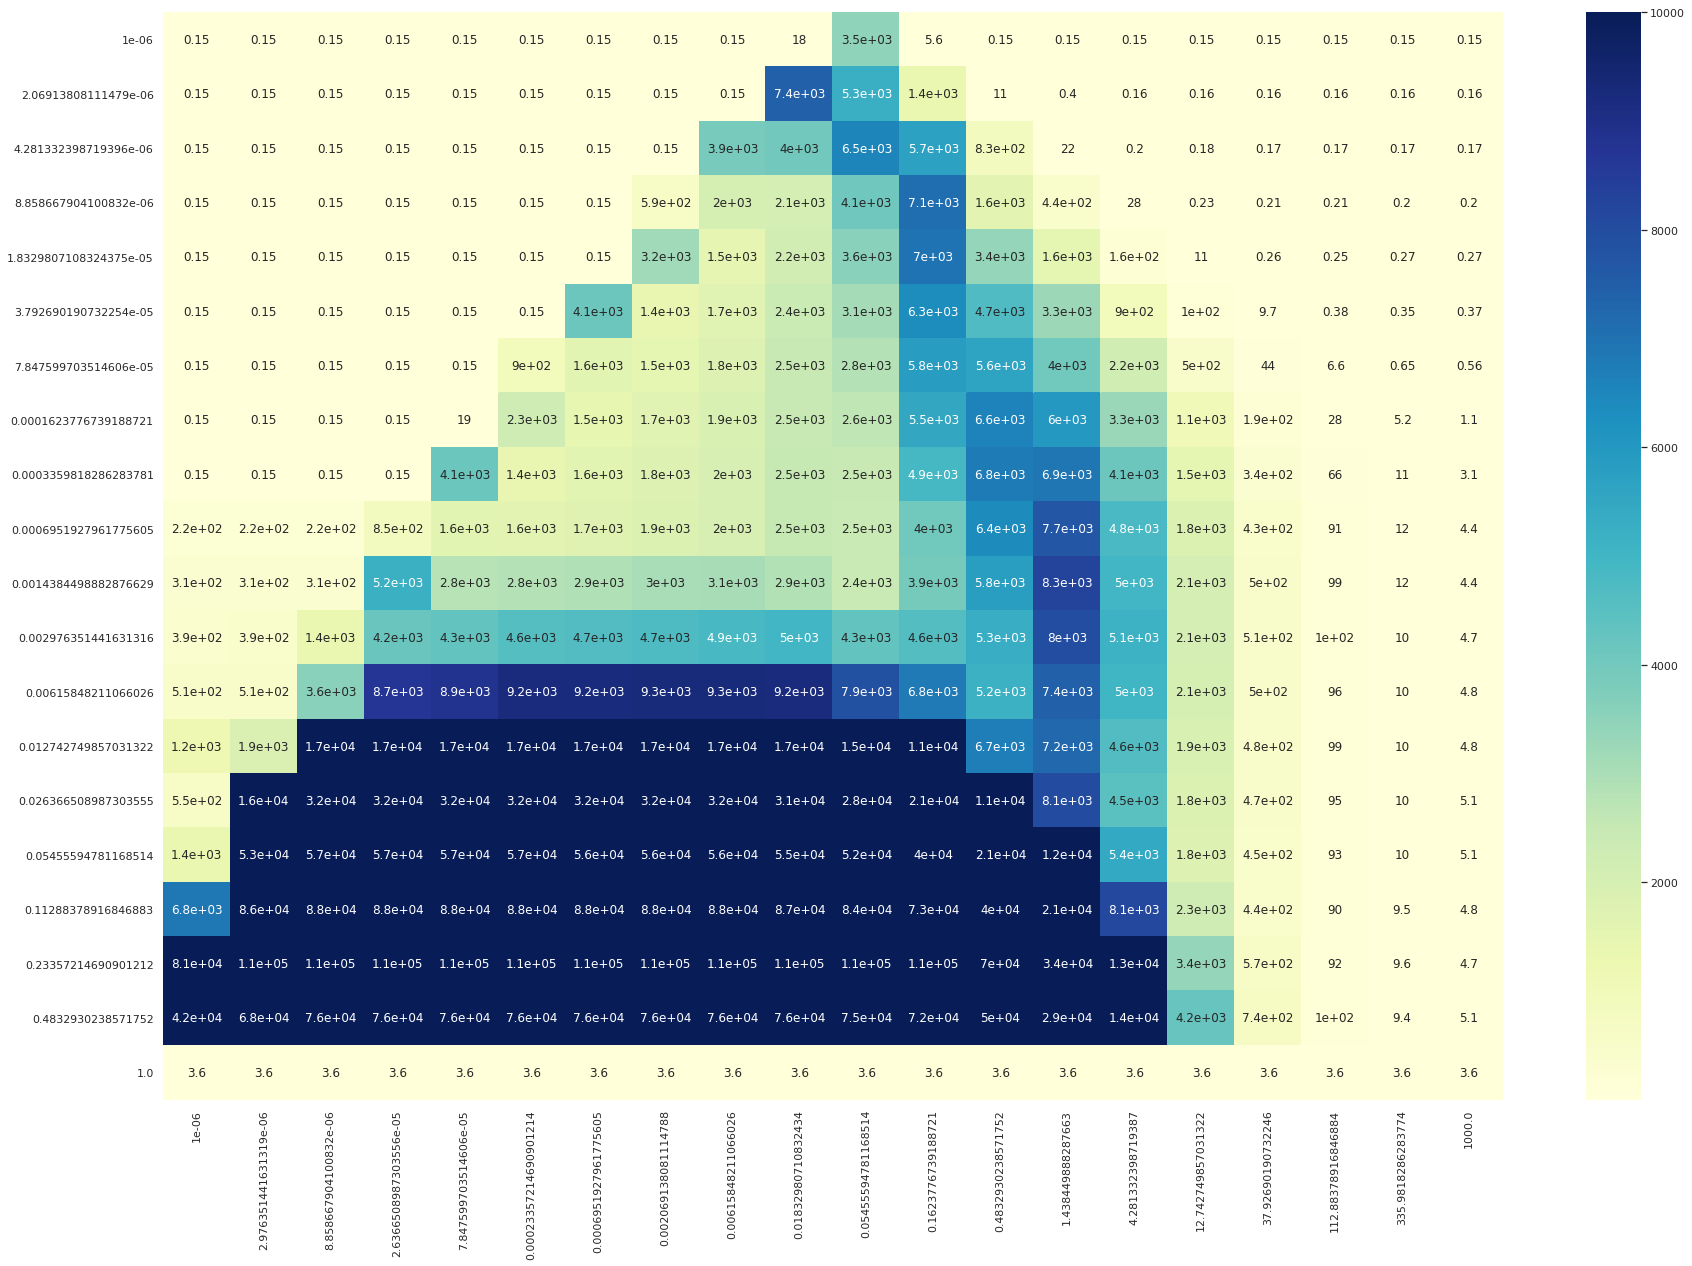

In [79]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap((np.power(fprateslist,3) * totalSizeList), xticklabels=gammas, yticklabels = nus, cmap="YlGnBu",vmax=1e4, annot=True)

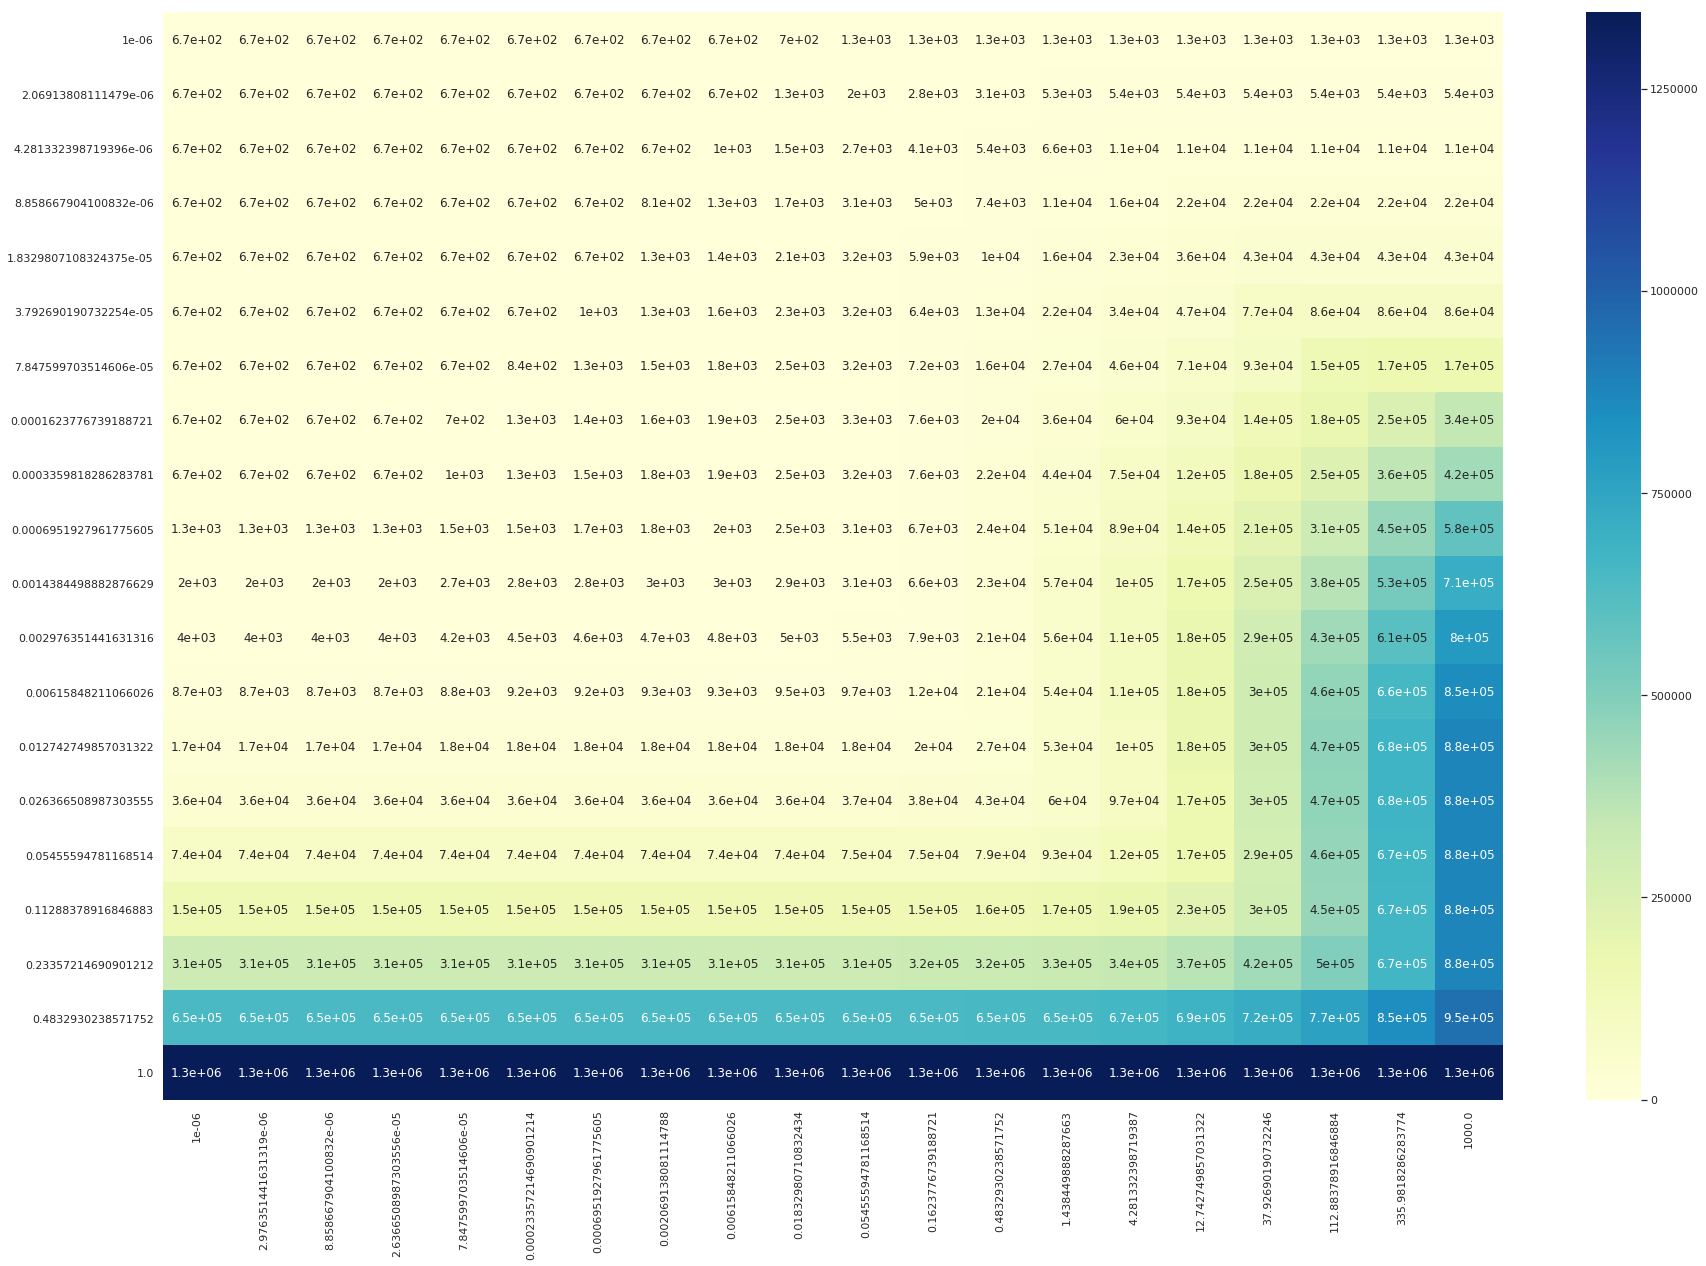

In [80]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0, annot=True)

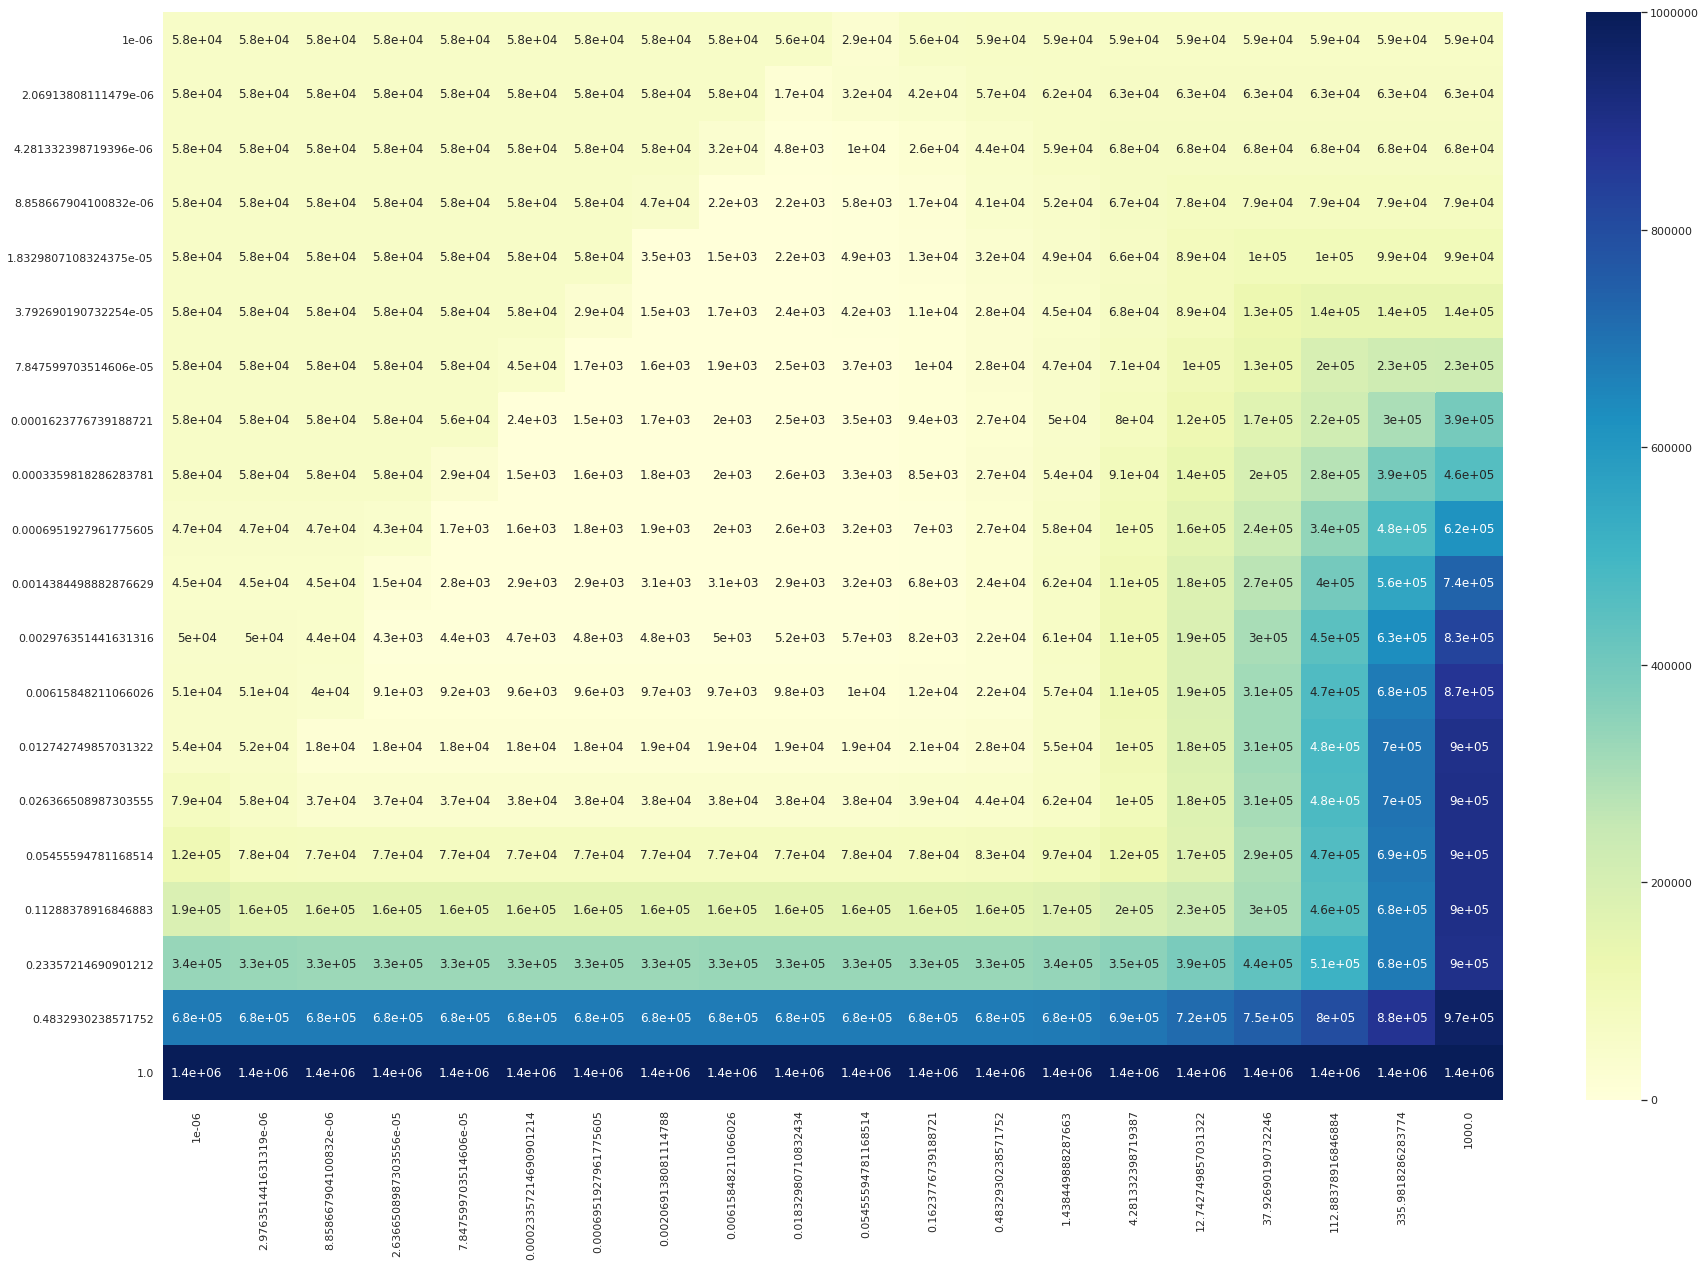

In [81]:
import seaborn as sns; sns.set(rc={'figure.figsize':(30,20)})
ax = sns.heatmap(modelSizeList+bfsizelist, xticklabels=gammas, yticklabels = nus, cmap="YlGnBu", vmin=0,vmax = 1e6, annot=True)

In [ ]:
modelSizeList + bfsizelist*0

In [ ]:
fpdic

In [ ]:
namePrefix = "core"
coreobs = loadObservations(0.1,1.0)
coreBf = loadBloomFilters(0.1,1.0)
print(sumsizeofbloom(coreBf))

In [ ]:
coreobs

In [93]:
np.where(nus==minpair[0])[0][0]

5

In [1]:
nunumber = 18
# nunumber = np.where(nus==minpair[0])[0][0]+1
gammanumber = 16
# gammanumber = np.where(gammas==minpair[1])[0][0]+1
tempmodel = loadModel(nus[nunumber-1],gammas[gammanumber-1])
print(nus[nunumber-1],gammas[gammanumber-1])

NameError: name 'loadModel' is not defined

In [ ]:
namePrefix

In [ ]:
tempmodel.fit_status_

In [ ]:
tempmodel.offset_

In [ ]:
len(tempmodel.support_)

In [ ]:
tempmodel.support_

In [ ]:
tempmodel.support_vectors_

In [ ]:
len(set(tempmodel.dual_coef_[0]))

In [ ]:
len(tempmodel.dual_coef_[0])

In [ ]:
tempmodel.dual_coef_[0].tolist().count(1.0)

In [ ]:
tempmodel?

In [276]:
tempmodel.intercept_

AttributeError: 'dict' object has no attribute 'intercept_'

In [ ]:
type(tempmodel.support_)

In [ ]:
tempmodel.support_.dtype

In [ ]:
tempmodel.support_vectors_.dtype

In [ ]:
tempmodel.dual_coef_.dtype

In [275]:
tempmodel.intercept_

AttributeError: 'dict' object has no attribute 'intercept_'

In [279]:
clf.intercept_
clf.score_samples(thisScaleddata[0:4])

array([0.00542842, 0.00528173, 0.0054745 , 0.00498572])

In [ ]:
8*(tempmodel.support_vectors_.shape[0]*tempmodel.support_vectors_.shape[1])+ 8*(tempmodel.dual_coef_.shape[0]*tempmodel.dual_coef_.shape[1]) + 4*(tempmodel.support_.shape[0])

In [280]:
clf.intercept_

array([-0.00524432])

In [281]:
clf.score_samples(thisScaleddata[0:4]) + clf.intercept_

array([ 1.84107106e-04,  3.74181852e-05,  2.30188589e-04, -2.58593912e-04])

In [ ]:
tempmodel.support_.shape[0]

In [ ]:
sumsizeofmodelssvmReal(models)

In [ ]:
# nunumber = 18
# gammanumber = 18
# # tempmodel = loadModel(nus[nunumber-1],gammas[gammanumber-1])
# tempmodel = trainFnTol(nus[nunumber-1],gammas[gammanumber-1],1e-5)
# print(nus[nunumber-1],gammas[gammanumber-1])

In [ ]:
# namePrefix = namePrefix + "tol1e-5"
# persistModel(tempmodel,nus[nunumber-1],gammas[gammanumber-1])

In [264]:
ssTableNumber = 4
temptableData = ssTableData[ssTableNumber]
clf = tempmodel[str(ssTableNumber)][0]
xx, yy = np.meshgrid(
    np.linspace(
        min(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[0]), 
        max(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[0]), 500), 
    np.linspace(
        min(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[1]), 
        max(scalers[ssTableNumber].transform(temptableData.reshape(-1,2)).T[1]), 500))
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
thisScaleddata = scalers[ssTableNumber].transform(temptableData)
thistablepredicitons = clf.predict(thisScaleddata)



In [265]:
testData = []
for i in range(len(ssTableData)):
    if i==ssTableNumber:
        continue
    thistabledata = ssTableData[i]
    for j in range(0, len(thistabledata), skipFactor):
        testData.append(thistabledata[j])
testData = np.array(testData)

In [266]:
testScaleddata = scalers[ssTableNumber].transform(testData)
testtablepredicitons = clf.predict(testScaleddata)

In [267]:
errorTestCases = np.array([testScaleddata[i] for i in range(len(testScaleddata)) if testtablepredicitons[i]==1])

In [268]:
errorTestCases

array([[ 0.24484054,  1.96411284],
       [ 0.23619428, -0.85595774],
       [ 0.23317601, -0.93088321],
       ...,
       [ 1.11597715, -0.22183501],
       [ 1.11452651, -0.03681602],
       [ 1.10635483,  1.62226787]])

In [269]:
errorTrainCases = np.array([thisScaleddata[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1 ])

In [270]:
(len(errorTrainCases))*1.0/(len(thisScaleddata))

0.415

In [271]:
(len(errorTrainCases))*1.0/(len(thisScaleddata)) - nu

0.31499999999999995

In [272]:
rightTrainCases = np.array([thisScaleddata[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==1 ])

In [273]:
rightTrainCases

array([[ 0.2552208 , -0.88567608],
       [ 0.25341085,  0.23736998],
       [ 0.25221428, -2.28515673],
       ...,
       [ 1.18387703, -0.1847252 ],
       [ 1.19044315, -0.51406782],
       [ 1.1846118 ,  0.17602775]])

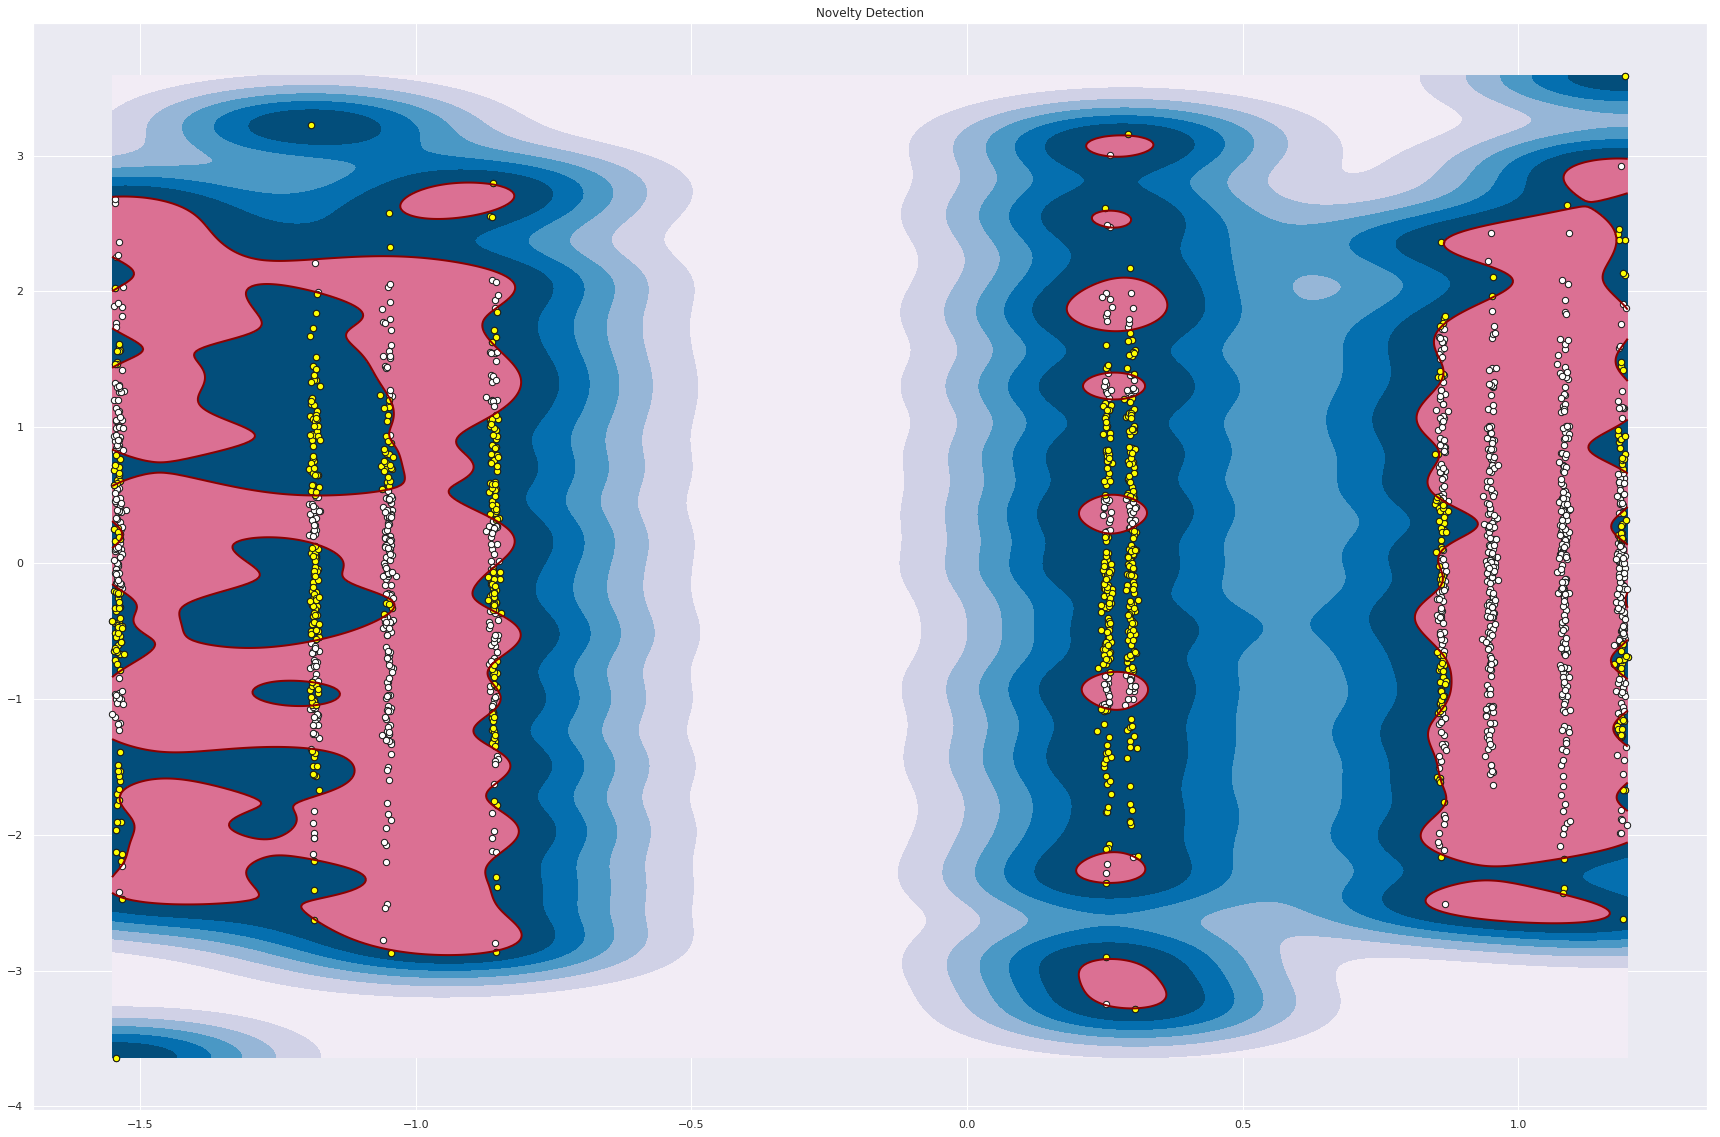

In [274]:

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
s = 40

# testData = np.array([ssTableData[i] for i in ssTableData if i!=ssTableNumber]).reshape(-1,2)
# b2 = plt.scatter(errorTestCases[:, 0], errorTestCases[:, 1], c='blueviolet', s=s, edgecolors='k')
b1 = plt.scatter(
    scalers[ssTableNumber].transform(ssTableData[ssTableNumber])[:, 0], 
    scalers[ssTableNumber].transform(ssTableData[ssTableNumber])[:, 1], c='white', s=s, edgecolors='k')
b3 = plt.scatter(errorTrainCases[:,0], errorTrainCases[:,1], c='yellow', s=s, edgecolors='k')
# b3 = plt.scatter(rightTrainCases[:,0], rightTrainCases[:,1], c='yellow', s=s, edgecolors='k')

# b4 = plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c= 'green', s=s, edgecolors='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 0]*0+2, c='gold', s=s,
#                 edgecolors='k')
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.show()
# plt.legend([a.collections[0], b1, b2],
#            ["learned frontier", "training observations",
#             "test observations"],
#            prop=matplotlib.font_manager.FontProperties(size=11))
# plt.xlabel(
#     "error train: %d/%d ; errors test: %d/%d ; false positives: %d ; fpr: %f"
#     % (truePositive_bf, truePositive, falsePositive_c, (falsePositive + trueNegative), falsePositive, fprate))
# plt.show()


In [ ]:
plt.savefig("plots/"+namePrefix + str(nus[nunumber-1])+"_"+str(gammas[gammanumber-1]) +"_"+ str(ssTableNumber) +"_"+ str(nunumber)+"_"+str(gammanumber)+".png")


In [ ]:

errorTrainCases =  np.array(errorTrainCases)

In [ ]:
map(scalers[0].transform, ssTableData[0])

In [ ]:
thisScaleddata = scalers[ssTableNumber].transform(temptableData)
thistablepredicitons = clf.predict(thisScaleddata)
[thisScaleddata[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1]

In [ ]:
thistablepredicitons.tolist().count(-1)

In [ ]:
thistablepredicitons.tolist().count(1)

In [ ]:
np.linspace(Z.min(), 0, 7)

In [ ]:
Z.max()

In [ ]:
clf.get_params()

In [ ]:
tempscores = clf.score_samples(thisScaleddata)

In [ ]:
wrongscores = [tempscores[i] for i in range(len(thisScaleddata)) if thistablepredicitons[i]==-1]

In [ ]:
min(wrongscores)

In [ ]:
max(wrongscores)

In [ ]:
tempscores = tempscores.tolist()


In [ ]:
tempscores.sort(reverse=True)

In [ ]:
tempscores

In [ ]:
clf.intercept_

In [ ]:
np.sort(wrongscores + clf.intercept_[0])

In [ ]:
plt.hist(np.sort(wrongscores + clf.intercept_[0]), normed=True, bins=40)
plt.ylabel('Probability');

In [ ]:
np.sort(tempscores)

In [ ]:
tempscores

In [ ]:
errorTrainCases

In [ ]:
wrongscores

In [ ]:
clf.support_vectors_

In [ ]:
scoressup = clf.score_samples(clf.support_vectors_)
predictionssup = clf.predict(clf.support_vectors_)

In [ ]:
np.sort(scoressup+clf.intercept_[0])[-15000:]

In [ ]:
plt.hist(np.sort(scoressup+clf.intercept_[0]), normed=True, bins=400)
plt.ylabel('Probability');

In [ ]:
len(scoressup)